##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [320]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Semantic Search with Approximate Nearest Neighbors and Text Embeddings

# OKC data essay0 my self summary


original source https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_semantic_approximate_nearest_neighbors.ipynb#scrollTo=m8qGUZLgJNk1


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_semantic_approximate_nearest_neighbors"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_semantic_approximate_nearest_neighbors.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf2_semantic_approximate_nearest_neighbors.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/tf2_semantic_approximate_nearest_neighbors.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/nnlm-en-dim128/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This tutorial illustrates how to generate embeddings from a [TensorFlow Hub](https://tfhub.dev) (TF-Hub) model given input data, and build an approximate nearest neighbours (ANN) index using the extracted embeddings. The index can then be used for real-time similarity matching and retrieval.

When dealing with a large corpus of data, it's not efficient to perform exact matching by scanning the whole repository to find the most similar items to a given query in real-time. Thus, we use an approximate similarity matching algorithm which allows us to trade off a little bit of accuracy in finding exact nearest neighbor matches for a significant boost in speed.

In this tutorial, we show an example of real-time text search over a corpus of news headlines to find the headlines that are most similar to a query. Unlike keyword search, this captures the semantic similarity encoded in the text embedding.

The steps of this tutorial are:
1. Download sample data.
2. Generate embeddings for the data using a TF-Hub model
3. Build an ANN index for the embeddings
4. Use the index for similarity matching

We use [Apache Beam](https://beam.apache.org/documentation/programming-guide/) to generate the embeddings from the TF-Hub model. We also use Spotify's [ANNOY](https://github.com/spotify/annoy) library to build the approximate nearest neighbours index.

### More models
For models that have the same architecture but were trained on a different language, refer to [this](https://tfhub.dev/google/collections/nnlm/1) collection. [Here](https://tfhub.dev/s?module-type=text-embedding) you can find all text embeddings that are currently hosted on [tfhub.dev](tfhub.dev). 

## Setup

Install the required libraries.

In [321]:
!pip install apache_beam
!pip install 'scikit_learn~=0.23.0'  # For gaussian_random_matrix.
!pip install annoy

     |████████████████████████████████| 9.7 MB 5.8 MB/s 
     |████████████████████████████████| 62 kB 930 kB/s 
     |████████████████████████████████| 151 kB 58.4 MB/s 
     |████████████████████████████████| 829 kB 46.9 MB/s 
     |████████████████████████████████| 2.3 MB 59.9 MB/s 
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=bcd3b75604d8c5e77829ccdf53966d2285003490134d38100619cb9928ef708d
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78546 sha256=01403700475e994a20782652c6d8b440eed1d79694eb85f8e7086fc1d5ae7368
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=1ac755c5a552edfb5b106aad4dc1331bcfebcd617b6be690c54b110e28336b2f
  Stored in directory: /root/.cache

     |████████████████████████████████| 6.8 MB 6.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


     |████████████████████████████████| 646 kB 6.8 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=394543 sha256=25897dd932b604d001baeb13c1380e744619c957d8b5f2b5be4373983d20b773
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


Import the required libraries

In [322]:
import os
import sys
import pickle
from collections import namedtuple
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import apache_beam as beam
from apache_beam.transforms import util
import tensorflow as tf
import tensorflow_hub as hub
import annoy
from sklearn.random_projection import gaussian_random_matrix

In [323]:
print('TF version: {}'.format(tf.__version__))
print('TF-Hub version: {}'.format(hub.__version__))
print('Apache Beam version: {}'.format(beam.__version__))

TF version: 2.6.0
TF-Hub version: 0.12.0
Apache Beam version: 2.31.0


## 1. Download Sample Data




In [324]:
# [A Million News Headlines](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/SYBGZL#) dataset contains news headlines published over a period of 15 years sourced from the reputable Australian Broadcasting Corp. (ABC). This news dataset has a summarised historical record of noteworthy events in the globe from early-2003 to end-2017 with a more granular focus on Australia. 
# 
# **Format**: Tab-separated two-column data: 1) publication date and 2) headline text. We are only interested in the headline text.

# !wget 'https://dataverse.harvard.edu/api/access/datafile/3450625?format=tab&gbrecs=true' -O raw.tsv
# !wc -l raw.tsv
# !head raw.tsv


In [325]:
### Mount your Google Drive to Collaboratory
from google.colab import drive 
drive.mount('/content/gdrive')

### Now you will see your Google Drive files in the left pane (file explorer). Right click on the file that you need to import and select çopy path. Then import as usual in pandas, using this copied path.
import pandas as pd 
df = pd.read_csv('/content/gdrive/MyDrive/_UCLA thesis/r code 00/okcupid_profiles.csv')

### look at available features
df.columns


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

In [326]:
df.head
df.dtypes
df.shape
df['essay0'].head

<bound method NDFrame.head of 0        about me:<br />\n<br />\ni would love to think...
1        i am a chef: this is what that means.<br />\n1...
2        i'm not ashamed of much, but writing public te...
3                i work in a library and go to school. . .
4        hey how's it going? currently vague on the pro...
                               ...                        
59941    vibrant, expressive, caring optimist. i love b...
59942    i'm nick.<br />\ni never know what to write ab...
59943    hello! i enjoy traveling, watching movies, and...
59944    "all i have in this world are my balls and my ...
59945    is it odd that having a little "enemy" status ...
Name: essay0, Length: 59946, dtype: object>

In [327]:
df.iloc[27059]['essay0']

'<b>updates:</b><br />\n<i>**april 2012: i\'m back! in berkeley. at least for a year or\nso.**</i><br />\n<br />\n<i>**january 1, 2012: i\'m sailing south to mexico from the sf bay\narea. currently in san diego for just a few more days and would\nlove to meet other folks who know the good breweries, hikes, and\nsecrets of the town.**</i><br />\n<br />\n<b>...and on to the profile!</b><br />\ni have a history of rambling about. freight trains, hiking boots, a\ngolden thumb, a motorcycle, and sailing vessels have all played\nroles. i might have a thing for mobility.<br />\n<br />\nrationality, debate, and hard data excite me. i like clever games\nand edgy humor that crosses the line. i find beauty in efficiency\nand sustainability, innovative solutions, diy, and open\nsource.<br />\n<br />\ni am facetious, literal, and 3d<br />\n<br />\nalso, the okc app say they are giving me "powerful and awesome\ndating capabilities". i have my reservations, but you be the judge.'

In [328]:
### remove html format
df['essay0'] = df['essay0'].str.replace('<br />',' ')
df['essay0'] = df['essay0'].str.replace('</b>','')
df['essay0'] = df['essay0'].str.replace('<b>','')
df['essay0'] = df['essay0'].str.replace('</i>','')
df['essay0'] = df['essay0'].str.replace('<i>','')
df['essay0'] = df['essay0'].str.replace("*",'')
df['essay0'] = df['essay0'].str.replace('\\n',' ')
df['essay0'] = df['essay0'].str.replace('"','')
df['essay0'] = df['essay0'].str.replace('&amp; ','')
df['essay0'] = df['essay0'].str.replace('    ',' ')

df.iloc[27059]['essay0']


"updates:  april 2012: i'm back! in berkeley. at least for a year or so. january 1, 2012: i'm sailing south to mexico from the sf bay area. currently in san diego for just a few more days and would love to meet other folks who know the good breweries, hikes, and secrets of the town. ...and on to the profile!  i have a history of rambling about. freight trains, hiking boots, a golden thumb, a motorcycle, and sailing vessels have all played roles. i might have a thing for mobility. rationality, debate, and hard data excite me. i like clever games and edgy humor that crosses the line. i find beauty in efficiency and sustainability, innovative solutions, diy, and open source. i am facetious, literal, and 3d also, the okc app say they are giving me powerful and awesome dating capabilities. i have my reservations, but you be the judge."

In [329]:
df[['age', 'sex', 'orientation', 'essay0']].to_csv('raw.tsv', sep = '\t', index=True)


In [330]:
!wc -l raw.tsv
!head raw.tsv

59947 raw.tsv
	age	sex	orientation	essay0
0	22	m	straight	about me: i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and concepts. i forge odd metaphors instead of reciting cliches. like the simularities between a friend of mine's house and an underwater salt mine. my favorite word is salt by the way (weird choice i know). to me most things in life are better as metaphors. i seek to make myself a little better everyday, in some productively lazy way. got tired of tying my shoes. considered hiring a five year old, but would probably have to tie both of our shoes... decided to only wear leather shoes dress shoes. about you: you love to have really serious, really deep conversations about really silly stuff. you have to be willing to snap me out of a light hearted rant with a kiss. you don't have to be funny, but you have to be able to make me laugh. you 

For simplicity, we only keep the essay (1 column)

In [331]:
!rm -r corpus
!mkdir corpus

with open('corpus/text.txt', 'w') as out_file:
  with open('raw.tsv', 'r') as in_file:
    for line in in_file:
      headline = line.split('\t')[4].strip().strip('<br />').strip('\\n').strip('"').strip('&amp; ')
      out_file.write(headline+"\n")
      

rm: cannot remove 'corpus': No such file or directory


In [332]:
!wc -l corpus/text.txt
!head corpus/text.txt
!tail corpus/text.txt

59947 corpus/text.txt
essay0
bout me: i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and concepts. i forge odd metaphors instead of reciting cliches. like the simularities between a friend of mine's house and an underwater salt mine. my favorite word is salt by the way (weird choice i know). to me most things in life are better as metaphors. i seek to make myself a little better everyday, in some productively lazy way. got tired of tying my shoes. considered hiring a five year old, but would probably have to tie both of our shoes... decided to only wear leather shoes dress shoes. about you: you love to have really serious, really deep conversations about really silly stuff. you have to be willing to snap me out of a light hearted rant with a kiss. you don't have to be funny, but you have to be able to make me laugh. you should be able to bend spoons 

## 2. Generate Embeddings for the Data.

In this tutorial, we use the [Neural Network Language Model (NNLM)](https://tfhub.dev/google/nnlm-en-dim128/2) to generate embeddings for the headline data. The sentence embeddings can then be easily used to compute sentence level meaning similarity. We run the embedding generation process using Apache Beam.

### Embedding extraction method

In [333]:
embed_fn = None

def generate_embeddings(text, model_url, random_projection_matrix=None):
  # Beam will run this function in different processes that need to
  # import hub and load embed_fn (if not previously loaded)
  global embed_fn
  if embed_fn is None:
    embed_fn = hub.load(model_url)
  embedding = embed_fn(text).numpy()
  if random_projection_matrix is not None:
    embedding = embedding.dot(random_projection_matrix)
  return text, embedding


### Convert to tf.Example method

In [334]:
def to_tf_example(entries):
  examples = []

  text_list, embedding_list = entries
  for i in range(len(text_list)):
    text = text_list[i]
    embedding = embedding_list[i]

    features = {
        'text': tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[text.encode('utf-8')])),
        'embedding': tf.train.Feature(
            float_list=tf.train.FloatList(value=embedding.tolist()))
    }
  
    example = tf.train.Example(
        features=tf.train.Features(
            feature=features)).SerializeToString(deterministic=True)
  
    examples.append(example)
  
  return examples

### Beam pipeline

In [335]:
def run_hub2emb(args):
  '''Runs the embedding generation pipeline'''

  options = beam.options.pipeline_options.PipelineOptions(**args)
  args = namedtuple("options", args.keys())(*args.values())

  with beam.Pipeline(args.runner, options=options) as pipeline:
    (
        pipeline
        | 'Read sentences from files' >> beam.io.ReadFromText(
            file_pattern=args.data_dir)
        | 'Batch elements' >> util.BatchElements(
            min_batch_size=args.batch_size, max_batch_size=args.batch_size)
        | 'Generate embeddings' >> beam.Map(
            generate_embeddings, args.model_url, args.random_projection_matrix)
        | 'Encode to tf example' >> beam.FlatMap(to_tf_example)
        | 'Write to TFRecords files' >> beam.io.WriteToTFRecord(
            file_path_prefix='{}/emb'.format(args.output_dir),
            file_name_suffix='.tfrecords')
    )

### Generating Random Projection Weight Matrix

[Random projection](https://en.wikipedia.org/wiki/Random_projection) is a simple, yet powerful technique used to reduce the dimensionality of a set of points which lie in Euclidean space. For a theoretical background, see the [Johnson-Lindenstrauss lemma](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma).

Reducing the dimensionality of the embeddings with random projection means less time needed to build and query the ANN index.

In this tutorial we use [Gaussian Random Projection](https://en.wikipedia.org/wiki/Random_projection#Gaussian_random_projection) from the [Scikit-learn](https://scikit-learn.org/stable/modules/random_projection.html#gaussian-random-projection) library.

In [336]:
def generate_random_projection_weights(original_dim, projected_dim):
  random_projection_matrix = None
  random_projection_matrix = gaussian_random_matrix(
      n_components=projected_dim, n_features=original_dim).T
  print("A Gaussian random weight matrix was creates with shape of {}".format(random_projection_matrix.shape))
  print('Storing random projection matrix to disk...')
  with open('random_projection_matrix', 'wb') as handle:
    pickle.dump(random_projection_matrix, 
                handle, protocol=pickle.HIGHEST_PROTOCOL)
        
  return random_projection_matrix

### Set parameters
If you want to build an index using the original embedding space without random projection, set the `projected_dim` parameter to `None`. Note that this will slow down the indexing step for high-dimensional embeddings.

In [337]:
model_url = 'https://tfhub.dev/google/nnlm-en-dim128/2' #@param {type:"string"}
projected_dim = 64  #@param {type:"number"}

### Run pipeline

In [338]:
import tempfile

output_dir = tempfile.mkdtemp()
original_dim = hub.load(model_url)(['']).shape[1]
random_projection_matrix = None

if projected_dim:
  random_projection_matrix = generate_random_projection_weights(
      original_dim, projected_dim)

args = {
    'job_name': 'hub2emb-{}'.format(datetime.utcnow().strftime('%y%m%d-%H%M%S')),
    'runner': 'DirectRunner',
    'batch_size': 1024,
    'data_dir': 'corpus/*.txt',
    'output_dir': output_dir,
    'model_url': model_url,
    'random_projection_matrix': random_projection_matrix,
}

print("Pipeline args are set.")
args

A Gaussian random weight matrix was creates with shape of (128, 64)
Storing random projection matrix to disk...
Pipeline args are set.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function gaussian_random_matrix is deprecated; gaussian_random_matrix is deprecated in 0.22 and will be removed in version 0.24.
  return fun(*args, **kwargs)


{'batch_size': 1024,
 'data_dir': 'corpus/*.txt',
 'job_name': 'hub2emb-210825-065940',
 'model_url': 'https://tfhub.dev/google/nnlm-en-dim128/2',
 'output_dir': '/tmp/tmpxae7a_fe',
 'random_projection_matrix': array([[ 0.0660165 , -0.11049933, -0.01289875, ..., -0.02909003,
          0.14823018, -0.10136278],
        [-0.16399022, -0.16957579,  0.0395859 , ..., -0.19792849,
          0.1371488 ,  0.08766651],
        [-0.19616936, -0.06804855,  0.14662771, ...,  0.01576469,
         -0.11482953,  0.07221867],
        ...,
        [ 0.02865571,  0.02788268,  0.06717285, ...,  0.01152371,
         -0.09430825,  0.26389908],
        [-0.0006537 ,  0.24829747, -0.07811753, ...,  0.07229618,
          0.04804197, -0.04177106],
        [ 0.15004971, -0.07849109,  0.07014271, ..., -0.03045276,
          0.04513862, -0.12957535]]),
 'runner': 'DirectRunner'}

In [339]:
print("Running pipeline...")
%time run_hub2emb(args)
print("Pipeline is done.")

Running pipeline...


         0.14823018, -0.10136278],
       [-0.16399022, -0.16957579,  0.0395859 , ..., -0.19792849,
         0.1371488 ,  0.08766651],
       [-0.19616936, -0.06804855,  0.14662771, ...,  0.01576469,
        -0.11482953,  0.07221867],
       ...,
       [ 0.02865571,  0.02788268,  0.06717285, ...,  0.01152371,
        -0.09430825,  0.26389908],
       [-0.0006537 ,  0.24829747, -0.07811753, ...,  0.07229618,
         0.04804197, -0.04177106],
       [ 0.15004971, -0.07849109,  0.07014271, ..., -0.03045276,
         0.04513862, -0.12957535]])}


CPU times: user 10.5 s, sys: 7.33 s, total: 17.8 s
Wall time: 10.8 s
Pipeline is done.


In [340]:
!ls {output_dir}

emb-00000-of-00001.tfrecords


Read some of the generated embeddings...

In [341]:
embed_file = os.path.join(output_dir, 'emb-00000-of-00001.tfrecords')
sample = 5

# Create a description of the features.
feature_description = {
    'text': tf.io.FixedLenFeature([], tf.string),
    'embedding': tf.io.FixedLenFeature([projected_dim], tf.float32)
}

def _parse_example(example):
  # Parse the input `tf.Example` proto using the dictionary above.
  return tf.io.parse_single_example(example, feature_description)

dataset = tf.data.TFRecordDataset(embed_file)
for record in dataset.take(sample).map(_parse_example):
  print("{}: {}".format(record['text'].numpy().decode('utf-8'), record['embedding'].numpy()[:10]))


essay0: [-0.03122744 -0.16579565  0.06399856  0.10387922  0.04670178 -0.07571636
 -0.08043614 -0.23096699 -0.04450044  0.07400575]
bout me: i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and concepts. i forge odd metaphors instead of reciting cliches. like the simularities between a friend of mine's house and an underwater salt mine. my favorite word is salt by the way (weird choice i know). to me most things in life are better as metaphors. i seek to make myself a little better everyday, in some productively lazy way. got tired of tying my shoes. considered hiring a five year old, but would probably have to tie both of our shoes... decided to only wear leather shoes dress shoes. about you: you love to have really serious, really deep conversations about really silly stuff. you have to be willing to snap me out of a light hearted rant with a kiss. yo

## 3. Build the ANN Index for the Embeddings

[ANNOY](https://github.com/spotify/annoy) (Approximate Nearest Neighbors Oh Yeah) is a C++ library with Python bindings to search for points in space that are close to a given query point. It also creates large read-only file-based data structures that are mapped into memory. It is built and used by [Spotify](https://www.spotify.com) for music recommendations. If you are interested you can play along with other alternatives to ANNOY such as [NGT](https://github.com/yahoojapan/NGT), [FAISS](https://github.com/facebookresearch/faiss), etc. 

In [342]:
def build_index(embedding_files_pattern, index_filename, vector_length, 
    metric='angular', num_trees=100):
  '''Builds an ANNOY index, angular is for cosine similarity'''

  annoy_index = annoy.AnnoyIndex(vector_length, metric=metric)
  # Mapping between the item and its identifier in the index
  mapping = {}

  embed_files = tf.io.gfile.glob(embedding_files_pattern)
  num_files = len(embed_files)
  print('Found {} embedding file(s).'.format(num_files))

  item_counter = 0
  for i, embed_file in enumerate(embed_files):
    print('Loading embeddings in file {} of {}...'.format(i+1, num_files))
    dataset = tf.data.TFRecordDataset(embed_file)
    for record in dataset.map(_parse_example):
      text = record['text'].numpy().decode("utf-8")
      embedding = record['embedding'].numpy()
      mapping[item_counter] = text
      annoy_index.add_item(item_counter, embedding)
      item_counter += 1
      if item_counter % 100000 == 0:
        print('{} items loaded to the index'.format(item_counter))

  print('A total of {} items added to the index'.format(item_counter))

  print('Building the index with {} trees...'.format(num_trees))
  annoy_index.build(n_trees=num_trees)
  print('Index is successfully built.')
  
  print('Saving index to disk...')
  annoy_index.save(index_filename)
  print('Index is saved to disk.')
  print("Index file size: {} GB".format(
    round(os.path.getsize(index_filename) / float(1024 ** 3), 2)))
  annoy_index.unload()

  print('Saving mapping to disk...')
  with open(index_filename + '.mapping', 'wb') as handle:
    pickle.dump(mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('Mapping is saved to disk.')
  print("Mapping file size: {} MB".format(
    round(os.path.getsize(index_filename + '.mapping') / float(1024 ** 2), 2)))

In [343]:
embedding_files = "{}/emb-*.tfrecords".format(output_dir)
embedding_dimension = projected_dim
index_filename = "index"

!rm {index_filename}
!rm {index_filename}.mapping

%time build_index(embedding_files, index_filename, embedding_dimension)

rm: cannot remove 'index': No such file or directory
rm: cannot remove 'index.mapping': No such file or directory
Found 1 embedding file(s).
Loading embeddings in file 1 of 1...
A total of 59947 items added to the index
Building the index with 100 trees...
Index is successfully built.
Saving index to disk...
Index is saved to disk.
Index file size: 0.1 GB
Saving mapping to disk...
Mapping is saved to disk.
Mapping file size: 34.34 MB
CPU times: user 37.5 s, sys: 2.48 s, total: 40 s
Wall time: 27.5 s


In [344]:
!ls

corpus	index	       random_projection_matrix  sample_data
gdrive	index.mapping  raw.tsv


## 4. Use the Index for Similarity Matching
Now we can use the ANN index to find essays that are semantically close to an input query.

### Load the index and the mapping files

In [345]:
index = annoy.AnnoyIndex(embedding_dimension)
index.load(index_filename, prefault=True)
print('Annoy index is loaded.')
with open(index_filename + '.mapping', 'rb') as handle:
  mapping = pickle.load(handle)
print('Mapping file is loaded.')


Annoy index is loaded.
Mapping file is loaded.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  """Entry point for launching an IPython kernel.


### Similarity matching method

In [346]:
def find_similar_items(embedding, num_matches=5):
  '''Finds similar items to a given embedding in the ANN index'''
  ids, distance = index.get_nns_by_vector(
  embedding, num_matches, search_k=-1, include_distances=True)
  closest_ids = [i-1 for i in ids]
  closest_distance = [d for d in distance]
  items = zip(closest_distance, closest_ids)
  return items

### Extract embedding from a given query

In [347]:
# Load the TF-Hub model
print("Loading the TF-Hub model...")
%time embed_fn = hub.load(model_url)
print("TF-Hub model is loaded.")

random_projection_matrix = None
if os.path.exists('random_projection_matrix'):
  print("Loading random projection matrix...")
  with open('random_projection_matrix', 'rb') as handle:
    random_projection_matrix = pickle.load(handle)
  print('random projection matrix is loaded.')

def extract_embeddings(query):
  '''Generates the embedding for the query'''
  query_embedding =  embed_fn([query])[0].numpy()
  if random_projection_matrix is not None:
    query_embedding = query_embedding.dot(random_projection_matrix)
  return query_embedding


Loading the TF-Hub model...
CPU times: user 513 ms, sys: 443 ms, total: 956 ms
Wall time: 967 ms
TF-Hub model is loaded.
Loading random projection matrix...
random projection matrix is loaded.


In [348]:
extract_embeddings("Hello Machine Learning!").shape

(64,)

In [349]:
df.iloc[44786, 6]

"i am a vegetarian/vegan compassionate woman. i love the outdoors, animals, music, baseball (giants, mets in that order), laughter and great conversation. i am generally a homebody but love adventures as well, both local and distant. i love hiking, yoga, board games, trivia, movies, theater (don't do enough of that), concerts. i have an 9-year-old son, who lives with me 50% of the time, and a fluffy white dog. my most wonderful moments include closeness with friends and family and enjoying the simple pleasures in life. i am not materialistic, quite minimalist actually, but at the same time i enjoy pampering myself now and again with a trip to hawaii or some other lovely destination. i work in publishing and enjoy my job. previously spent my career in the music business."

In [350]:
df.iloc[44786, 6]
extract_embeddings(df.iloc[44786, 6])

array([ 0.54168578, -0.56553122, -0.07175943, -0.77093127, -0.04414394,
       -0.39697145,  0.24970142, -0.02849179,  0.37392793, -0.04718598,
        0.18333749, -0.1915281 ,  0.3674779 , -0.21151452,  0.14641188,
        0.16037631,  0.08465813,  0.10058691, -0.22790516,  0.43973281,
        0.00738801,  0.07588551,  0.20602816,  0.31550012, -0.18607997,
       -0.01388707,  0.3566698 ,  0.0964928 ,  0.09560617, -0.08097378,
        0.51050101,  0.05614195, -0.66841061,  0.05889824, -0.10345485,
       -0.61483351, -0.1555757 , -0.09621028, -0.32955042, -0.24820537,
       -0.01520445,  0.39243558, -0.62641456, -0.03750807, -0.38987756,
        0.24580709,  0.1890075 , -0.08383566,  0.40532149,  0.11938382,
       -0.2591919 , -0.11175392,  0.05810026, -0.0781974 , -0.57584358,
        0.36789885,  0.26792796, -0.20936835,  0.27779763, -0.10226463,
       -0.03237577,  0.00205923, -0.39889166,  0.15223481])

### Enter a query to find the most similar items

In [351]:
#@title { run: "auto" }
query = "well-traveled, over-educated, but so far under-appreciated. i grew up in santa monica, did my undergrad at berkeley, got my ma in london, and then returned to the bay area for law school. now an attorney in san francisco." #@param {type:"string"}
### has index 44786 from original dataset index 0 to 59946

print("Generating embedding for the query...")
%time query_embedding = extract_embeddings(query)

print("")
print("Finding relevant items in the index...")
%time items = find_similar_items(query_embedding, 10)

print("")
print("Results:")
print("=========")
for item in items:
  print(item)

Generating embedding for the query...
CPU times: user 490 µs, sys: 1.98 ms, total: 2.47 ms
Wall time: 1.85 ms

Finding relevant items in the index...
CPU times: user 3.9 ms, sys: 0 ns, total: 3.9 ms
Wall time: 5.97 ms

Results:
(0.0, 39915)
(0.5490050315856934, 22648)
(0.5995000004768372, 51733)
(0.6040979623794556, 24356)
(0.6079872846603394, 3947)
(0.609613299369812, 52801)
(0.6128406524658203, 26774)
(0.6137959957122803, 42933)
(0.6179713010787964, 19232)
(0.6192324757575989, 58518)


In [358]:
### combine essay embeddings into an array
essays_array = []
essays_array.append(extract_embeddings(df.iloc[39915, 6]))
essays_array.append(extract_embeddings(df.iloc[39915, 6]))
essays_array.append(extract_embeddings(df.iloc[22648, 6]))
essays_array.append(extract_embeddings(df.iloc[51733, 6]))

### calculate cosine similarity from essay embeddings, each of 64 dimensions
from scipy.spatial.distance import cdist
1 - cdist(essays_array, essays_array, metric='cosine')


array([[1.        , 1.        , 0.84929663, 0.82029992],
       [1.        , 1.        , 0.84929663, 0.82029992],
       [0.84929663, 0.84929663, 1.        , 0.85996136],
       [0.82029992, 0.82029992, 0.85996136, 1.        ]])

Cosine similarity of 0.73 (see above using reduced 64 dimensions) vs 0.73 (using all 128 dimensions). We've maintained high accuracy even when using half the number of dimensions.

In [359]:
df.iloc[39915, 6]

'well-traveled, over-educated, but so far under-appreciated. i grew up in santa monica, did my undergrad at berkeley, got my ma in london, and then returned to the bay area for law school. now an attorney in san francisco.'

In [360]:
df.iloc[22648, 6]

'i live on the peninsula (belmont). worked as an engineering manager in silicon valley. now retired and widowed. two grown kids and 2 grandsons. education: b.s. in engineering from uc berkeley. certificate in management from univ of santa clara. i have traveled extensively in europe, asia, and the middle east. my primary hobby is fly fishing, and i have traveled to canada, mexico, alaska, the bahamas to do it and even fished in japan.'

In [361]:
df.iloc[51733, 6] 24356

"hi, i'm from santa cruz, ca.  i moved to san francisco about five years ago to go to college, and i spent one of those years studying abroad in japan! graduated last year and just landed a job. i commute to silicon valley for work. i'm still getting used to the city. i'd like to explore more of sf! you could call me a japanophile, i like japan and learning japanese! it's hard but fun! and i like traveling in japan and hopefully other countries in the future."

In [362]:
df.iloc[24356, 6]

'i grew up in cincinnati, oh and moved to the bay area 7 years ago. i love the san francisco and consider this city my home.'

In [368]:
#@title { run: "auto" }
query = "my names jake.  i'm a creative guy and i look for the same in others. i'm easy going, practical and i don't have many hang ups. i appreciate life and try to live it to the fullest. i'm sober and have been for the past few years. i love music and i play guitar. i like tons of different bands. i'm an artist and i love to paint/draw etc. and i love creative people. i've got to say i'm not too big on internet dating. you cant really get an earnest impression of anyone from a few polished paragraphs. but we'll see, you never know." #@param {type:"string"}
### has index 44786 from original dataset index 0 to 59946

print("Generating embedding for the query...")
%time query_embedding = extract_embeddings(query)

print("")
print("Finding relevant items in the index...")
%time items = find_similar_items(query_embedding, 10)

print("")
print("Results:")
print("=========")
for item in items:
  print(item)

Generating embedding for the query...
CPU times: user 4.43 ms, sys: 0 ns, total: 4.43 ms
Wall time: 3.03 ms

Finding relevant items in the index...
CPU times: user 3.82 ms, sys: 0 ns, total: 3.82 ms
Wall time: 3.83 ms

Results:
(0.05677066370844841, 9)
(0.30047085881233215, 57761)
(0.31410855054855347, 35923)
(0.32267317175865173, 30757)
(0.3247021734714508, 37425)
(0.3254150152206421, 29250)
(0.32982006669044495, 3159)
(0.33059248328208923, 38015)
(0.3357379138469696, 34418)
(0.33940207958221436, 46325)


In [366]:
df.iloc[9, 6]

"my names jake.  i'm a creative guy and i look for the same in others. i'm easy going, practical and i don't have many hang ups. i appreciate life and try to live it to the fullest. i'm sober and have been for the past few years. i love music and i play guitar. i like tons of different bands. i'm an artist and i love to paint/draw etc. and i love creative people. i've got to say i'm not too big on internet dating. you cant really get an earnest impression of anyone from a few polished paragraphs. but we'll see, you never know."

In [369]:
df.iloc[57761, 6]

"i will give this a shot, but i'm no poet! i'm a positive person who likes to be around people. i try to find the best in everybody. i have a huge heart, i'm genuine, caring, and kind. i don't take things too seriously. you can usually find me laughing about something.  i love my family and i enjoy spending time with my parents (maybe because i'm an only child?). i'm actually first generation since both of my parents are czech immigrants (they have an interesting story).  i'm from the bay area, went to ucla for college, and then moved to prague for a few years and now i'm back where i started. i found a career in the video game industry and i feel very fortunate for many reasons. i love spending time with my friends and i'm lucky to work with amazing people that are like my second family.  i really enjoy traveling. i love exploring new places and immersing myself in foreign cultures.  otherwise, i am happy if i can find time to oil paint and practice yoga. i love trying new restaurants

In [370]:
df.iloc[35923, 6]

"i'm italian. i'm discovering the world, living in different places between italy and unite states making a cool job, very exiting and challenging.  i like discover things and be free to do what i like to do.  i love learning and speak with new people to know their stories and feeling differences and similitudes between me and them.  open-minded .. sincere (and expect my partner to be as well)... dreamer (but hard worker to make dreams real) .. happy about my life (and ready to change if something doesn't satisfy me anymore) .. driven by curiosity, looking for challenges.  i love travel and i'm interested in different cultures and ways of living.  i love sushi and sashimi, thai, indian, mexican, and of course italian. i love the good wine but i'm little ignorant about it!  i also love listen music but i'm not that kind of guy that know everything about it.  i used to have a motorcycles but after an incident i decided to be more calm and use only the car or the bicycle! ;-)  i have live

In [371]:
df.iloc[30757, 6]

"i'm a very friendly, caring, and open-minded person. people fascinate me, so i'm often inclined to ask a lot of questions (it's a good thing; it just means i'm interested). i love to laugh and somehow, i find that i'm often attracted to witty and sarcastic human beings. i love exploring and learning new things. i have an endless bucket list of things i would like to accomplish before i die, and i am most excited to do so. i work hard and i play hard. i think it's important to find that balance. in a relationship, i value honesty, respect, and communication, but most importantly, i long for romance and passion. i believe a relationship is reciprocal and both parties should get the same thing they put into it."

# Load USE module

Load Universal Sentence Encoder module
code source https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder


In [1]:
### setup
%%capture
!pip3 install seaborn

In [2]:
### Load the Universal Sentence Encoder's TF Hub module

from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## Import and clean dating essays

In [3]:
### Mount your Google Drive to Collaboratory
from google.colab import drive 
drive.mount('/content/gdrive')

### Now you will see your Google Drive files in the left pane (file explorer). Right click on the file that you need to import and select çopy path. Then import as usual in pandas, using this copied path.
import pandas as pd 
df = pd.read_csv('/content/gdrive/MyDrive/_UCLA thesis/r code 00/okcupid_profiles.csv')

### look at available features
df.columns


Mounted at /content/gdrive


Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'essay0',
       'essay1', 'essay2', 'essay3', 'essay4', 'essay5', 'essay6', 'essay7',
       'essay8', 'essay9', 'ethnicity', 'height', 'income', 'job',
       'last_online', 'location', 'offspring', 'orientation', 'pets',
       'religion', 'sex', 'sign', 'smokes', 'speaks', 'status'],
      dtype='object')

In [ ]:
df.head
df.dtypes
df.shape
df['essay0'].head

<bound method NDFrame.head of 0        about me:<br />\n<br />\ni would love to think...
1        i am a chef: this is what that means.<br />\n1...
2        i'm not ashamed of much, but writing public te...
3                i work in a library and go to school. . .
4        hey how's it going? currently vague on the pro...
                               ...                        
59941    vibrant, expressive, caring optimist. i love b...
59942    i'm nick.<br />\ni never know what to write ab...
59943    hello! i enjoy traveling, watching movies, and...
59944    "all i have in this world are my balls and my ...
59945    is it odd that having a little "enemy" status ...
Name: essay0, Length: 59946, dtype: object>

In [ ]:
df.iloc[27059]['essay0']

'<b>updates:</b><br />\n<i>**april 2012: i\'m back! in berkeley. at least for a year or\nso.**</i><br />\n<br />\n<i>**january 1, 2012: i\'m sailing south to mexico from the sf bay\narea. currently in san diego for just a few more days and would\nlove to meet other folks who know the good breweries, hikes, and\nsecrets of the town.**</i><br />\n<br />\n<b>...and on to the profile!</b><br />\ni have a history of rambling about. freight trains, hiking boots, a\ngolden thumb, a motorcycle, and sailing vessels have all played\nroles. i might have a thing for mobility.<br />\n<br />\nrationality, debate, and hard data excite me. i like clever games\nand edgy humor that crosses the line. i find beauty in efficiency\nand sustainability, innovative solutions, diy, and open\nsource.<br />\n<br />\ni am facetious, literal, and 3d<br />\n<br />\nalso, the okc app say they are giving me "powerful and awesome\ndating capabilities". i have my reservations, but you be the judge.'

In [4]:
### remove html format
df['essay0'] = df['essay0'].str.replace('<br />',' ')
df['essay0'] = df['essay0'].str.replace('</b>','')
df['essay0'] = df['essay0'].str.replace('<b>','')
df['essay0'] = df['essay0'].str.replace('</i>','')
df['essay0'] = df['essay0'].str.replace('<i>','')
df['essay0'] = df['essay0'].str.replace("*",'')
df['essay0'] = df['essay0'].str.replace('\\n',' ')
df['essay0'] = df['essay0'].str.replace('"','')
df['essay0'] = df['essay0'].str.replace('&amp; ','')
df['essay0'] = df['essay0'].str.replace('    ',' ')

df.iloc[27059]['essay0']


"updates:  april 2012: i'm back! in berkeley. at least for a year or so. january 1, 2012: i'm sailing south to mexico from the sf bay area. currently in san diego for just a few more days and would love to meet other folks who know the good breweries, hikes, and secrets of the town. ...and on to the profile!  i have a history of rambling about. freight trains, hiking boots, a golden thumb, a motorcycle, and sailing vessels have all played roles. i might have a thing for mobility. rationality, debate, and hard data excite me. i like clever games and edgy humor that crosses the line. i find beauty in efficiency and sustainability, innovative solutions, diy, and open source. i am facetious, literal, and 3d also, the okc app say they are giving me powerful and awesome dating capabilities. i have my reservations, but you be the judge."

In [5]:
# make age groupings
conditions = [
              (df['age'] <= 29),
              (df['age'] >= 30) & (df['age'] <= 39),
              (df['age'] >= 39) & (df['age'] <= 49),
              (df['age'] >= 50)
              ]

# create a list of the values we want to assign for each condition
values = ['20s', '30s', '40s', '50s and up']

# create a new column and use np.select to assign values to it using our lists as arguments
df['age_group'] = np.select(conditions, values)

df.groupby('age_group')['sex'].count()


age_group
20s           28741
30s           19846
40s            7338
50s and up     4021
Name: sex, dtype: int64

In [6]:
### see how well-populated each feature is
df.count()

age            59946
body_type      54650
diet           35551
drinks         56961
drugs          45866
education      53318
essay0         54458
essay1         52374
essay2         50308
essay3         48470
essay4         49409
essay5         49096
essay6         46175
essay7         47495
essay8         40721
essay9         47343
ethnicity      54266
height         59943
income         59946
job            51748
last_online    59946
location       59946
offspring      24385
orientation    59946
pets           40025
religion       39720
sex            59946
sign           48890
smokes         54434
speaks         59896
status         59946
age_group      59946
dtype: int64

In [7]:
### mean and median age, by gender
df.groupby('sex')['age'].mean()
df.groupby('sex')['age'].median()

sex
f    30
m    30
Name: age, dtype: int64

## Get 500+ dimensions per self-summary essay using USE module

In [210]:
### Pick out a few features like age, gender, orientation to predict/classify based on essay embeddings
### Use 10,000 essays to get embeddings for shorter run-time
df_toPredict = df[['age_group', 'sex', 'orientation', 'essay0']][:10000]

### Replace blank essays with "none"
df_toPredict['essay0'] = df_toPredict['essay0'].fillna("none")

### Put essays into a list format
essays = df_toPredict['essay0'].tolist()

### Reduce logging output
logging.set_verbosity(logging.ERROR)

### Generate embeddings of the essays based on USE
essay_embeddings = embed(essays)

essay_embeddings.shape


TensorShape([10000, 512])

In [211]:
### number of essays
essay_embeddings.shape[0]

10000

In [212]:
### number of dimensions per essay
essay_embeddings.shape[1]

512

In [213]:
### Look at embeddings for first 3 essays
for i, essay_embedding in enumerate(np.array(essay_embeddings[:3]).tolist()):
  print("\nMessage: {}".format(essays[i]))
  print("Embedding size: {}".format(len(essay_embedding)))
  print(essay_embedding)
 


Message: about me: i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say i can tell the difference. i love to talk about ideas and concepts. i forge odd metaphors instead of reciting cliches. like the simularities between a friend of mine's house and an underwater salt mine. my favorite word is salt by the way (weird choice i know). to me most things in life are better as metaphors. i seek to make myself a little better everyday, in some productively lazy way. got tired of tying my shoes. considered hiring a five year old, but would probably have to tie both of our shoes... decided to only wear leather shoes dress shoes. about you: you love to have really serious, really deep conversations about really silly stuff. you have to be willing to snap me out of a light hearted rant with a kiss. you don't have to be funny, but you have to be able to make me laugh. you should be able to bend spoons with your mind, an

# t-SNE on 512 dimensions
Project embedded vectors with 512 dimensions down to 2D for visualization using t-distributed stochastic neighbor embedding.

source code from https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_tsne.html



In [214]:
# 512 dimensions for each essay
X = essay_embeddings
X.shape

TensorShape([10000, 512])

In [215]:
### Fit and transform with TSNE into just 2 dimensions
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)


In [216]:
X_2d.shape

(10000, 2)

In [217]:
### limit USE embeddings to first 600 essays otherwise it's difficult to see almost 60,000 points
X_2d = X_2d[:600]

In [218]:
X_2d.shape

(600, 2)

### plot gender as the feature of interest

In [219]:
### extract gender as the feature (can be other features like age, sexual orientation, religion, etc) into an array
### limit it to first 600 essays similarly 

y = df['sex'][:600].to_numpy()
y.shape


(600,)

In [220]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,24.172424,-24.638241,m
1,8.023157,-0.582899,m
2,-2.633757,-37.238968,m
3,-14.507010,15.134922,m
4,-25.686228,12.643529,m
5,17.796125,13.880589,m
6,-9.988502,-17.605827,f
7,-56.908844,-46.633236,f
8,-49.413902,-45.298023,f
9,-2.683491,-2.991173,m


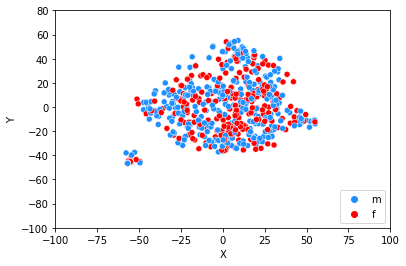

In [221]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['dodgerblue', 'red'],
                legend='full',
                data=tsne_df)

# control x and y limits
plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

### plot age as the feature of interest

In [222]:
# create a list of our conditions
conditions = [
              (df['age'] <= 29),
              (df['age'] >= 30) & (df['age'] <= 39),
              (df['age'] >= 39) & (df['age'] <= 49),
              (df['age'] >= 50)
              ]

# create a list of the values we want to assign for each condition
values = ['20s', '30s', '40s', '50s and up']

# create a new column and use np.select to assign values to it using our lists as arguments
df['age_group'] = np.select(conditions, values)

df.groupby('age_group')['sex'].count()


age_group
20s           28741
30s           19846
40s            7338
50s and up     4021
Name: sex, dtype: int64

In [223]:
### age as feature 'y'
### limit it to first 600 essays similarly 

y = df['age_group'][:600].to_numpy()
y.shape
y[:10]


array(['20s', '30s', '30s', '20s', '20s', '20s', '30s', '30s', '20s',
       '30s'], dtype=object)

In [224]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,24.172424,-24.638241,20s
1,8.023157,-0.582899,30s
2,-2.633757,-37.238968,30s
3,-14.507010,15.134922,20s
4,-25.686228,12.643529,20s
5,17.796125,13.880589,20s
6,-9.988502,-17.605827,30s
7,-56.908844,-46.633236,30s
8,-49.413902,-45.298023,20s
9,-2.683491,-2.991173,30s


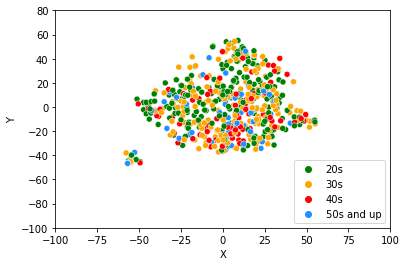

In [225]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['green','orange','red', 'dodgerblue'],
                legend='full',
                data=tsne_df)

# control x and y limits
plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')


### plot gender, age as the combined features of interest

In [226]:
### gender and age as feature 'y'
### limit it to first 600 essays similarly 

df['sex_age'] = df['sex'] + df['age_group']
y = df['sex_age'][:600].to_numpy()
y.shape
y[:10]


array(['m20s', 'm30s', 'm30s', 'm20s', 'm20s', 'm20s', 'f30s', 'f30s',
       'f20s', 'm30s'], dtype=object)

In [227]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,24.172424,-24.638241,m20s
1,8.023157,-0.582899,m30s
2,-2.633757,-37.238968,m30s
3,-14.507010,15.134922,m20s
4,-25.686228,12.643529,m20s
5,17.796125,13.880589,m20s
6,-9.988502,-17.605827,f30s
7,-56.908844,-46.633236,f30s
8,-49.413902,-45.298023,f20s
9,-2.683491,-2.991173,m30s


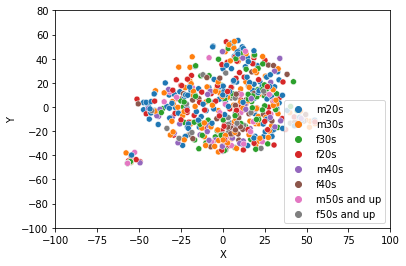

In [228]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                # palette=['red','dodgerblue'],
                legend='full',
                data=tsne_df)

# control x and y limits
plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

### plot religion as the feature of interest

In [229]:
df.groupby('religion')['sex'].count()

religion
agnosticism                                   2724
agnosticism and laughing about it             2496
agnosticism and somewhat serious about it      642
agnosticism and very serious about it          314
agnosticism but not too serious about it      2636
atheism                                       2175
atheism and laughing about it                 2074
atheism and somewhat serious about it          848
atheism and very serious about it              570
atheism but not too serious about it          1318
buddhism                                       403
buddhism and laughing about it                 466
buddhism and somewhat serious about it         359
buddhism and very serious about it              70
buddhism but not too serious about it          650
catholicism                                   1064
catholicism and laughing about it              726
catholicism and somewhat serious about it      548
catholicism and very serious about it          102
catholicism but not to

In [230]:
# create a list of our conditions
conditions = [
              (df['religion'].str.startswith('agnosticism', na=False) == True),
              (df['religion'].str.startswith('atheism', na=False) == True),
              (df['religion'].str.startswith('catholicism', na=False) == True),
              (df['religion'].str.startswith('christianity', na=False) == True)
              ]

# create a list of the values we want to assign for each condition
values = ['agnosticism', 'atheism', 'catholicism', 'christianity']

# create a new column and use np.select to assign values to it using our lists as arguments
df['religion_group'] = np.select(conditions, values, default=None)

df.groupby('religion_group')['sex'].count()


religion_group
agnosticism     8812
atheism         6985
catholicism     4758
christianity    5787
Name: sex, dtype: int64

In [231]:
### religion as feature 'y'
### limit it to first 600 essays similarly 

y = df['religion_group'][:600].to_numpy()
y.shape
y[:10]


array(['agnosticism', 'agnosticism', None, None, None, 'atheism', None,
       'christianity', 'christianity', 'atheism'], dtype=object)

In [232]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,24.172424,-24.638241,agnosticism
1,8.023157,-0.582899,agnosticism
2,-2.633757,-37.238968,None
3,-14.507010,15.134922,None
4,-25.686228,12.643529,None
5,17.796125,13.880589,atheism
6,-9.988502,-17.605827,None
7,-56.908844,-46.633236,christianity
8,-49.413902,-45.298023,christianity
9,-2.683491,-2.991173,atheism


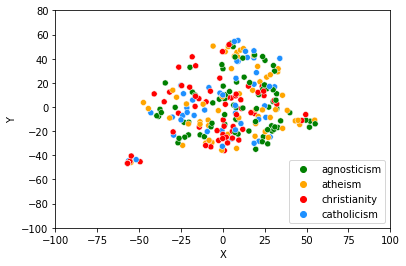

In [233]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['green','orange','red', 'dodgerblue'],
                legend='full',
                data=tsne_df)

# control x and y limits
plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

In [234]:
# # find 2 dimension representation of "I love God and my family"

# X_god = np.vstack((extract_embeddings("I like God Faith Bible"), 
#                    essays_array))

# X_god_2d = tsne.fit_transform(X_god)
# X_god_2d.shape

# X_god_2d[601-1]

In [235]:
# # find 2 dimension representation of "I like Parties Bars Clubs Drinking"

# X_party = np.vstack((extract_embeddings("I like Parties Bars Clubs Drinking"), 
#                      essays_array))

# X_party_2d = tsne.fit_transform(X_party)
# X_party_2d.shape

# X_party_2d[601-1]

### plot pet type as the feature of interest

In [236]:
df.groupby('pets')['sex'].count()

pets
dislikes cats                        122
dislikes dogs                         44
dislikes dogs and dislikes cats      196
dislikes dogs and has cats            81
dislikes dogs and likes cats         240
has cats                            1406
has dogs                            4134
has dogs and dislikes cats           552
has dogs and has cats               1474
has dogs and likes cats             2333
likes cats                          1063
likes dogs                          7224
likes dogs and dislikes cats        2029
likes dogs and has cats             4313
likes dogs and likes cats          14814
Name: sex, dtype: int64

In [237]:
# create a list of our conditions
conditions = [
              ((df['pets'] == 'likes dogs') == True),
              (df['pets'].str.startswith('likes dogs and dislikes cats', na=False) == True),
              ((df['pets'] == 'has dogs') == True),
              (df['pets'].str.startswith('has dogs and dislikes cats', na=False) == True),
              (df['pets'].str.startswith('likes dogs and likes cats', na=False) == True),
              (df['pets'].str.startswith('likes dogs and has cats', na=False) == True),
              (df['pets'].str.startswith('has dogs and likes cats', na=False) == True),
              (df['pets'].str.startswith('has dogs and has cats', na=False) == True),
              (df['pets'].str.startswith('likes cats', na=False) == True),
              (df['pets'].str.startswith('dislikes dogs and likes cats', na=False) == True),
              (df['pets'].str.startswith('has cats', na=False) == True),
              (df['pets'].str.startswith('dislikes dogs and has cats', na=False) == True)
              ]

# create a list of the values we want to assign for each condition
values = ['likes dogs', 'likes dogs', 'likes dogs', 'likes dogs', 
          'likes dogs+cats', 'likes dogs+cats', 'likes dogs+cats', 'likes dogs+cats',
          'likes cats', 'likes cats', 'likes cats', 'likes cats']

# create a new column and use np.select to assign values to it using our lists as arguments
df['pets_group'] = np.select(conditions, values, default=None)

df.groupby('pets_group')['sex'].count()


pets_group
likes cats          2790
likes dogs         13939
likes dogs+cats    22934
Name: sex, dtype: int64

In [238]:
### pets group as feature 'y'
### limit it to first 600 essays similarly 

y = df['pets_group'][:600].to_numpy()
y.shape
y[:10]


array(['likes dogs+cats', 'likes dogs+cats', 'likes cats', 'likes cats',
       'likes dogs+cats', 'likes cats', 'likes dogs+cats',
       'likes dogs+cats', 'likes dogs+cats', 'likes dogs+cats'],
      dtype=object)

In [239]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,24.172424,-24.638241,likes dogs+cats
1,8.023157,-0.582899,likes dogs+cats
2,-2.633757,-37.238968,likes cats
3,-14.507010,15.134922,likes cats
4,-25.686228,12.643529,likes dogs+cats
5,17.796125,13.880589,likes cats
6,-9.988502,-17.605827,likes dogs+cats
7,-56.908844,-46.633236,likes dogs+cats
8,-49.413902,-45.298023,likes dogs+cats
9,-2.683491,-2.991173,likes dogs+cats


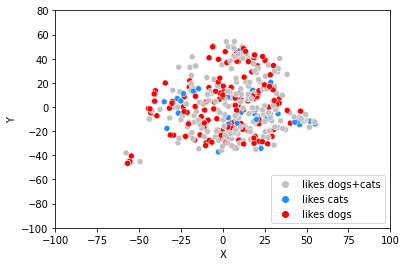

In [240]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['silver','dodgerblue','red'],
                legend='full',
                data=tsne_df)

# control x and y limits
plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

### What do 140/100/70/30 characters look like?

In [241]:
sample_essay = df.iloc[39915, 6]
sample_essay


'well-traveled, over-educated, but so far under-appreciated. i grew up in santa monica, did my undergrad at berkeley, got my ma in london, and then returned to the bay area for law school. now an attorney in san francisco.'

In [242]:
len(sample_essay)

221

In [243]:
sample_essay[:140]

'well-traveled, over-educated, but so far under-appreciated. i grew up in santa monica, did my undergrad at berkeley, got my ma in london, an'

In [244]:
sample_essay[:100]

'well-traveled, over-educated, but so far under-appreciated. i grew up in santa monica, did my underg'

In [245]:
sample_essay[:70]

'well-traveled, over-educated, but so far under-appreciated. i grew up '

In [246]:
sample_essay[:30]

'well-traveled, over-educated, '

In [247]:
sample_essay[:15]

'well-traveled, '

# Limit each essay to first 140 characters before running tSNE

## Get 500+ dimensions per self-summary essay using USE module

In [248]:
### Put 60,000 essays into a list format and limit each essay to first 140 CHARACTERS
essays = df_toPredict['essay0'].str[:140].tolist()

### Reduce logging output
logging.set_verbosity(logging.ERROR)

### Generate embeddings of the essays based on USE
essay_embeddings = embed(essays)

essay_embeddings.shape


TensorShape([10000, 512])

In [249]:
### number of essays
essay_embeddings.shape[0]

10000

In [250]:
### number of dimensions per essay
essay_embeddings.shape[1]

512

In [251]:
### Look at embeddings for first 3 essays
for i, essay_embedding in enumerate(np.array(essay_embeddings[:3]).tolist()):
  print("\nMessage: {}".format(essays[i]))
  print("Embedding size: {}".format(len(essay_embedding)))
  print(essay_embedding)
 


Message: about me: i would love to think that i was some some kind of intellectual: either the dumbest smart guy, or the smartest dumb guy. can't say
Embedding size: 512
[0.023479165509343147, 0.004693150985985994, 0.010991467162966728, -0.034298885613679886, -0.049837756901979446, 0.02228539250791073, 0.00018285155238118023, -0.05040298029780388, -0.008097777143120766, 0.06531720608472824, 0.008795004338026047, 0.03415548801422119, 0.023626260459423065, -0.058508969843387604, -0.04178917780518532, -0.09083178639411926, 0.06869864463806152, 0.05486031249165535, 0.02637956105172634, -0.08471161127090454, 0.06219624727964401, 0.011718680150806904, -0.07362914085388184, 0.045448776334524155, 0.029289962723851204, 0.027000296860933304, -0.022600211203098297, 0.03050336241722107, -0.027616264298558235, 0.013977529481053352, 0.008552650921046734, 0.05656544864177704, 0.04447074979543686, -0.050561949610710144, 0.05896063148975372, 0.06304030120372772, -0.014700882136821747, 0.00543927121907

In [252]:
# 512 dimensions for each essay
X = essay_embeddings
X.shape

TensorShape([10000, 512])

In [253]:
### Fit and transform with TSNE into just 2 dimensions
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)


In [254]:
X_2d.shape

(10000, 2)

In [255]:
### limit USE embeddings to first 600 essays otherwise it's difficult to see almost 60,000 points
X_2d = X_2d[:600]

In [256]:
X_2d.shape

(600, 2)

#### explore clusters by age (if any)


In [257]:
### age as feature 'y'
### limit it to first 600 essays similarly 

y = df['age_group'][:600].to_numpy()
y.shape
y[:10]


array(['20s', '30s', '30s', '20s', '20s', '20s', '30s', '30s', '20s',
       '30s'], dtype=object)

In [258]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,5.629079,21.943836,20s
1,14.100848,-11.351790,30s
2,22.683111,42.396519,30s
3,28.783670,-29.335352,20s
4,-1.979189,-12.730742,20s
5,-6.822151,-38.239109,20s
6,-0.006564,9.988421,30s
7,-46.320122,57.809746,30s
8,-36.148220,54.858612,20s
9,-21.201691,20.181311,30s


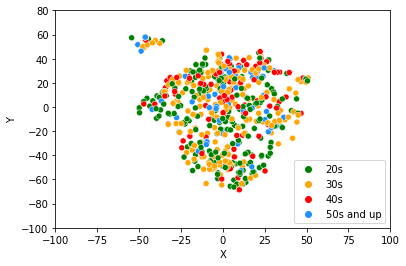

In [259]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['green','orange','red', 'dodgerblue'],
                legend='full',
                data=tsne_df)

plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

#### explore clusters by gender (if any)

In [260]:
### gender as feature 'y'
### limit it to first 600 essays similarly 

y = df['sex'][:600].to_numpy()
y.shape
y[:10]


array(['m', 'm', 'm', 'm', 'm', 'm', 'f', 'f', 'f', 'm'], dtype=object)

In [261]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,5.629079,21.943836,m
1,14.100848,-11.351790,m
2,22.683111,42.396519,m
3,28.783670,-29.335352,m
4,-1.979189,-12.730742,m
5,-6.822151,-38.239109,m
6,-0.006564,9.988421,f
7,-46.320122,57.809746,f
8,-36.148220,54.858612,f
9,-21.201691,20.181311,m


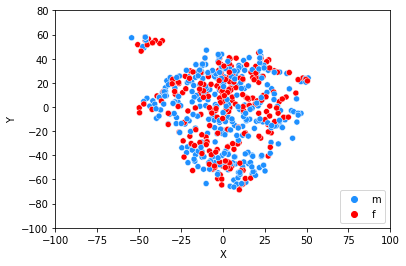

In [262]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['dodgerblue', 'red'],
                legend='full',
                data=tsne_df)

plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

#### explore clusters by pets (if any)

In [263]:
### age as feature 'y'
### limit it to first 600 essays similarly 

y = df['pets_group'][:600].to_numpy()
y.shape
y[:10]


array(['likes dogs+cats', 'likes dogs+cats', 'likes cats', 'likes cats',
       'likes dogs+cats', 'likes cats', 'likes dogs+cats',
       'likes dogs+cats', 'likes dogs+cats', 'likes dogs+cats'],
      dtype=object)

In [264]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,5.629079,21.943836,likes dogs+cats
1,14.100848,-11.351790,likes dogs+cats
2,22.683111,42.396519,likes cats
3,28.783670,-29.335352,likes cats
4,-1.979189,-12.730742,likes dogs+cats
5,-6.822151,-38.239109,likes cats
6,-0.006564,9.988421,likes dogs+cats
7,-46.320122,57.809746,likes dogs+cats
8,-36.148220,54.858612,likes dogs+cats
9,-21.201691,20.181311,likes dogs+cats


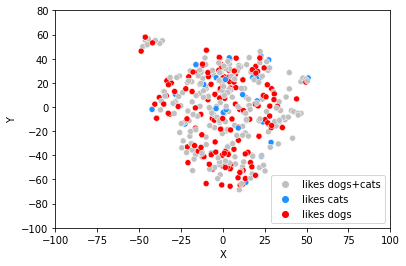

In [265]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['silver','dodgerblue','red'],
                legend='full',
                data=tsne_df)

plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

# Limit each essay to first 100 characters before running tSNE

## Get 500+ dimensions per self-summary essay using USE module

In [266]:
### Put 60,000 essays into a list format and limit each essay to first 100 CHARACTERS
essays = df_toPredict['essay0'].str[:100].tolist()

### Reduce logging output
logging.set_verbosity(logging.ERROR)

### Generate embeddings of the essays based on USE
essay_embeddings = embed(essays)

essay_embeddings.shape


TensorShape([10000, 512])

In [267]:
### number of essays
essay_embeddings.shape[0]

10000

In [268]:
### number of dimensions per essay
essay_embeddings.shape[1]

512

In [269]:
### Look at embeddings for first 3 essays
for i, essay_embedding in enumerate(np.array(essay_embeddings[:3]).tolist()):
  print("\nMessage: {}".format(essays[i]))
  print("Embedding size: {}".format(len(essay_embedding)))
  print(essay_embedding)
 


Message: about me: i would love to think that i was some some kind of intellectual: either the dumbest smart 
Embedding size: 512
[0.03485734388232231, 0.009265158325433731, 0.01760038174688816, -0.06441600620746613, -0.047016169875860214, 0.04137264937162399, -0.017817534506320953, -0.04286756366491318, -0.008092210628092289, 0.05288367718458176, 0.015806734561920166, 0.04009392485022545, 0.014123521745204926, -0.05834660306572914, -0.04711606726050377, -0.1007872223854065, 0.06489114463329315, 0.05554581061005592, 0.027149410918354988, -0.09475114941596985, 0.046226564794778824, -0.010702201165258884, -0.04987934231758118, 0.035115037113428116, 0.019081570208072662, 0.03310539573431015, 0.008348201401531696, 0.009216788224875927, 0.019456209614872932, 0.023098239675164223, -0.009195601567626, 0.041325751692056656, 0.031271886080503464, -0.0547269843518734, 0.05786827206611633, 0.06571962684392929, -0.01914214715361595, -0.012840072624385357, -0.008421367034316063, 0.0191001072525978

In [270]:
# 512 dimensions for each essay
X = essay_embeddings
X.shape

TensorShape([10000, 512])

In [271]:
### Fit and transform with TSNE into just 2 dimensions
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)


In [272]:
X_2d.shape

(10000, 2)

In [273]:
### limit USE embeddings to first 600 essays otherwise it's difficult to see almost 60,000 points
X_2d = X_2d[:600]

In [274]:
X_2d.shape

(600, 2)

#### explore clusters by age (if any)


In [275]:
### age as feature 'y'
### limit it to first 600 essays similarly 

y = df['age_group'][:600].to_numpy()
y.shape
y[:10]


array(['20s', '30s', '30s', '20s', '20s', '20s', '30s', '30s', '20s',
       '30s'], dtype=object)

In [276]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,20.749908,11.261766,20s
1,-2.489369,-4.011061,30s
2,-9.393891,39.965664,30s
3,-51.232613,-9.041437,20s
4,-11.972955,19.778116,20s
5,-19.738403,-33.098660,20s
6,27.241640,-5.372308,30s
7,66.251701,38.145538,30s
8,66.251701,38.145538,20s
9,-38.535030,7.159644,30s


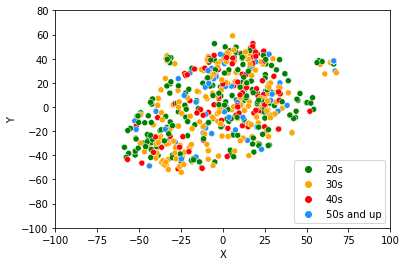

In [277]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['green','orange','red', 'dodgerblue'],
                legend='full',
                data=tsne_df)

plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

#### explore clusters by gender (if any)

In [278]:
### gender as feature 'y'
### limit it to first 600 essays similarly 

y = df['sex'][:600].to_numpy()
y.shape
y[:10]


array(['m', 'm', 'm', 'm', 'm', 'm', 'f', 'f', 'f', 'm'], dtype=object)

In [279]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,20.749908,11.261766,m
1,-2.489369,-4.011061,m
2,-9.393891,39.965664,m
3,-51.232613,-9.041437,m
4,-11.972955,19.778116,m
5,-19.738403,-33.098660,m
6,27.241640,-5.372308,f
7,66.251701,38.145538,f
8,66.251701,38.145538,f
9,-38.535030,7.159644,m


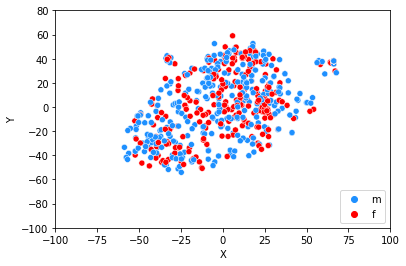

In [280]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['dodgerblue', 'red'],
                legend='full',
                data=tsne_df)

plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

#### explore clusters by pets (if any)

In [281]:
### age as feature 'y'
### limit it to first 600 essays similarly 

y = df['pets_group'][:600].to_numpy()
y.shape
y[:10]


array(['likes dogs+cats', 'likes dogs+cats', 'likes cats', 'likes cats',
       'likes dogs+cats', 'likes cats', 'likes dogs+cats',
       'likes dogs+cats', 'likes dogs+cats', 'likes dogs+cats'],
      dtype=object)

In [282]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,20.749908,11.261766,likes dogs+cats
1,-2.489369,-4.011061,likes dogs+cats
2,-9.393891,39.965664,likes cats
3,-51.232613,-9.041437,likes cats
4,-11.972955,19.778116,likes dogs+cats
5,-19.738403,-33.098660,likes cats
6,27.241640,-5.372308,likes dogs+cats
7,66.251701,38.145538,likes dogs+cats
8,66.251701,38.145538,likes dogs+cats
9,-38.535030,7.159644,likes dogs+cats


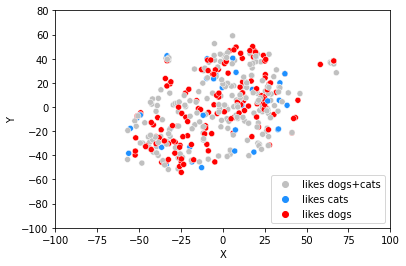

In [283]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['silver','dodgerblue','red'],
                legend='full',
                data=tsne_df)

plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

# Limit each essay to first 70 characters before running tSNE

## Get 500+ dimensions per self-summary essay using USE module

In [284]:
### Put 60,000 essays into a list format and limit each essay to first 70 CHARACTERS
essays = df_toPredict['essay0'].str[:70].tolist()

### Reduce logging output
logging.set_verbosity(logging.ERROR)

### Generate embeddings of the essays based on USE
essay_embeddings = embed(essays)

essay_embeddings.shape


TensorShape([10000, 512])

In [285]:
### number of essays
essay_embeddings.shape[0]

10000

In [286]:
### number of dimensions per essay
essay_embeddings.shape[1]

512

In [287]:
### Look at embeddings for first 3 essays
for i, essay_embedding in enumerate(np.array(essay_embeddings[:3]).tolist()):
  print("\nMessage: {}".format(essays[i]))
  print("Embedding size: {}".format(len(essay_embedding)))
  print(essay_embedding)
 


Message: about me: i would love to think that i was some some kind of intellect
Embedding size: 512
[0.04935307800769806, -0.02432057447731495, 0.00620273919776082, -0.08688366413116455, -0.05499397590756416, 0.003152810735628009, -0.040473319590091705, -0.03518327698111534, 0.01783018745481968, 0.03301742672920227, 0.05173883214592934, 0.030290167778730392, 0.03535831347107887, -0.06940899789333344, -0.05930230766534805, -0.11826207488775253, 0.06347888708114624, 0.04424702748656273, 0.012880311347544193, -0.07449071109294891, 0.04369984194636345, -0.009647638536989689, 0.003753972239792347, 0.04495256021618843, -0.008899567648768425, 0.018345041200518608, 0.02284071408212185, -0.01299311313778162, 0.029534613713622093, 0.0040750158950686455, -0.02450060099363327, 0.0015386813320219517, -0.01522482093423605, -0.02907351218163967, 0.03429722413420677, 0.07831799238920212, -0.015513437800109386, -0.019633717834949493, -0.006159359123557806, 0.03013644367456436, -0.0038400955963879824, 

In [288]:
# 512 dimensions for each essay
X = essay_embeddings
X.shape

TensorShape([10000, 512])

In [289]:
### Fit and transform with TSNE into just 2 dimensions
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)


In [290]:
X_2d.shape

(10000, 2)

In [291]:
### limit USE embeddings to first 600 essays otherwise it's difficult to see almost 60,000 points
X_2d = X_2d[:600]

In [292]:
X_2d.shape

(600, 2)

#### explore clusters by age (if any)


In [293]:
### age as feature 'y'
### limit it to first 600 essays similarly 

y = df['age_group'][:600].to_numpy()
y.shape
y[:10]


array(['20s', '30s', '30s', '20s', '20s', '20s', '30s', '30s', '20s',
       '30s'], dtype=object)

In [294]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,-21.955225,-17.965527,20s
1,14.804964,10.128975,30s
2,6.921198,-50.462303,30s
3,26.915731,6.035129,20s
4,-4.552914,-57.460190,20s
5,22.275574,37.703461,20s
6,-43.625206,-3.799210,30s
7,-12.970926,66.603210,30s
8,-5.529629,58.851101,20s
9,36.628868,-16.353580,30s


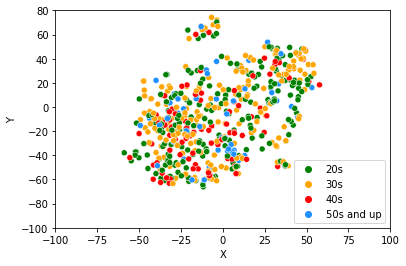

In [295]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['green','orange','red', 'dodgerblue'],
                legend='full',
                data=tsne_df)

plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

#### explore clusters by gender (if any)

In [296]:
### gender as feature 'y'
### limit it to first 600 essays similarly 

y = df['sex'][:600].to_numpy()
y.shape
y[:10]


array(['m', 'm', 'm', 'm', 'm', 'm', 'f', 'f', 'f', 'm'], dtype=object)

In [297]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,-21.955225,-17.965527,m
1,14.804964,10.128975,m
2,6.921198,-50.462303,m
3,26.915731,6.035129,m
4,-4.552914,-57.460190,m
5,22.275574,37.703461,m
6,-43.625206,-3.799210,f
7,-12.970926,66.603210,f
8,-5.529629,58.851101,f
9,36.628868,-16.353580,m


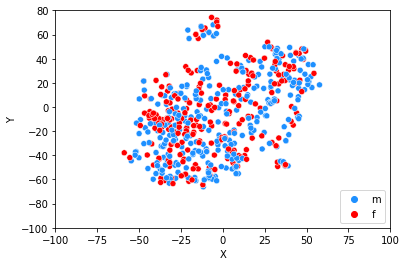

In [298]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['dodgerblue', 'red'],
                legend='full',
                data=tsne_df)

plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

#### explore clusters by pets (if any)

In [299]:
### age as feature 'y'
### limit it to first 600 essays similarly 

y = df['pets_group'][:600].to_numpy()
y.shape
y[:10]


array(['likes dogs+cats', 'likes dogs+cats', 'likes cats', 'likes cats',
       'likes dogs+cats', 'likes cats', 'likes dogs+cats',
       'likes dogs+cats', 'likes dogs+cats', 'likes dogs+cats'],
      dtype=object)

In [300]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,-21.955225,-17.965527,likes dogs+cats
1,14.804964,10.128975,likes dogs+cats
2,6.921198,-50.462303,likes cats
3,26.915731,6.035129,likes cats
4,-4.552914,-57.460190,likes dogs+cats
5,22.275574,37.703461,likes cats
6,-43.625206,-3.799210,likes dogs+cats
7,-12.970926,66.603210,likes dogs+cats
8,-5.529629,58.851101,likes dogs+cats
9,36.628868,-16.353580,likes dogs+cats


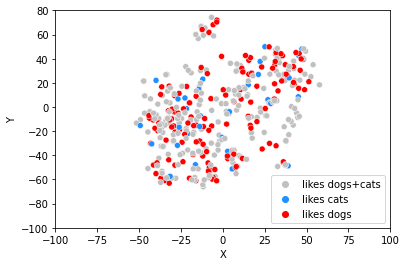

In [301]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['silver','dodgerblue','red'],
                legend='full',
                data=tsne_df)

plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

# Limit each essay to first 30 characters before running tSNE

## Get 500+ dimensions per self-summary essay using USE module

In [302]:
### Put 60,000 essays into a list format and limit each essay to first 30 CHARACTERS
essays = df_toPredict['essay0'].str[:30].tolist()

### Reduce logging output
logging.set_verbosity(logging.ERROR)

### Generate embeddings of the essays based on USE
essay_embeddings = embed(essays)

essay_embeddings.shape


TensorShape([10000, 512])

In [303]:
### number of essays
essay_embeddings.shape[0]

10000

In [304]:
### number of dimensions per essay
essay_embeddings.shape[1]

512

In [305]:
### Look at embeddings for first 3 essays
for i, essay_embedding in enumerate(np.array(essay_embeddings[:3]).tolist()):
  print("\nMessage: {}".format(essays[i]))
  print("Embedding size: {}".format(len(essay_embedding)))
  print(essay_embedding)
 


Message: about me: i would love to thin
Embedding size: 512
[0.023832930251955986, -0.07893353700637817, 0.03590754419565201, -0.07615678012371063, -0.00011310577974654734, -0.05550289899110794, -0.0002491366758476943, -0.006375941447913647, 0.051034778356552124, 0.0036641962360590696, 0.05657903477549553, -0.008133882656693459, 0.016596432775259018, -0.07197380065917969, -0.04374769702553749, -0.059572283178567886, -0.012331669218838215, 0.013077525421977043, -0.06989428400993347, -0.031656838953495026, 0.03858402371406555, -0.02799595519900322, 0.03116186521947384, -0.0016187848523259163, 0.008338348008692265, 0.0008511203923262656, 0.026141732931137085, -0.04563547670841217, -0.017071034759283066, 0.07697592675685883, -0.056769296526908875, -0.04847576096653938, -0.04271816834807396, -0.04120703041553497, 0.012858843430876732, 0.006738468538969755, -0.007460038177669048, 0.008046324364840984, -0.013843509368598461, -0.00659450888633728, -0.000187010140507482, 0.037474971264600754, 

In [306]:
# 512 dimensions for each essay
X = essay_embeddings
X.shape

TensorShape([10000, 512])

In [307]:
### Fit and transform with TSNE into just 2 dimensions
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)


In [308]:
X_2d.shape

(10000, 2)

In [309]:
### limit USE embeddings to first 600 essays otherwise it's difficult to see almost 60,000 points
X_2d = X_2d[:600]

In [310]:
X_2d.shape

(600, 2)

#### explore clusters by age (if any)


In [311]:
### age as feature 'y'
### limit it to first 600 essays similarly 

y = df['age_group'][:600].to_numpy()
y.shape
y[:10]


array(['20s', '30s', '30s', '20s', '20s', '20s', '30s', '30s', '20s',
       '30s'], dtype=object)

In [312]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,-26.080574,19.547459,20s
1,36.115513,-34.279251,30s
2,-12.263500,3.062195,30s
3,25.482992,-48.083694,20s
4,-42.908871,4.775987,20s
5,-36.903728,-26.639885,20s
6,23.438438,-7.518864,30s
7,-79.954247,21.043056,30s
8,-77.451561,19.400793,20s
9,-61.534077,-12.244956,30s


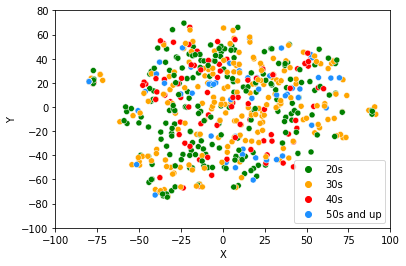

In [313]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['green','orange','red', 'dodgerblue'],
                legend='full',
                data=tsne_df)

plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

#### explore clusters by gender (if any)

In [314]:
### gender as feature 'y'
### limit it to first 600 essays similarly 

y = df['sex'][:600].to_numpy()
y.shape
y[:10]


array(['m', 'm', 'm', 'm', 'm', 'm', 'f', 'f', 'f', 'm'], dtype=object)

In [315]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,-26.080574,19.547459,m
1,36.115513,-34.279251,m
2,-12.263500,3.062195,m
3,25.482992,-48.083694,m
4,-42.908871,4.775987,m
5,-36.903728,-26.639885,m
6,23.438438,-7.518864,f
7,-79.954247,21.043056,f
8,-77.451561,19.400793,f
9,-61.534077,-12.244956,m


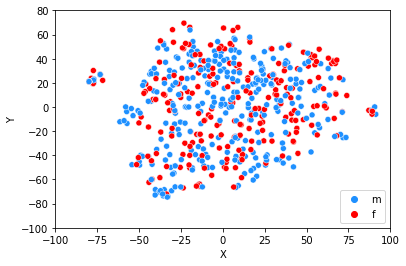

In [316]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['dodgerblue', 'red'],
                legend='full',
                data=tsne_df)

plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')

#### explore clusters by pets (if any)

In [317]:
### age as feature 'y'
### limit it to first 600 essays similarly 

y = df['pets_group'][:600].to_numpy()
y.shape
y[:10]


array(['likes dogs+cats', 'likes dogs+cats', 'likes cats', 'likes cats',
       'likes dogs+cats', 'likes cats', 'likes dogs+cats',
       'likes dogs+cats', 'likes dogs+cats', 'likes dogs+cats'],
      dtype=object)

In [318]:
tsne_df = pd.DataFrame({'X':X_2d[:,0],
                        'Y':X_2d[:,1],
                        'class':y})
tsne_df.head(10)


,X,Y,class
0,-26.080574,19.547459,likes dogs+cats
1,36.115513,-34.279251,likes dogs+cats
2,-12.263500,3.062195,likes cats
3,25.482992,-48.083694,likes cats
4,-42.908871,4.775987,likes dogs+cats
5,-36.903728,-26.639885,likes cats
6,23.438438,-7.518864,likes dogs+cats
7,-79.954247,21.043056,likes dogs+cats
8,-77.451561,19.400793,likes dogs+cats
9,-61.534077,-12.244956,likes dogs+cats


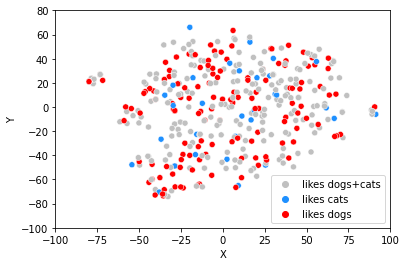

In [319]:
import seaborn as sns
sns.scatterplot(x="X", y="Y",
                hue="class",
                palette=['silver','dodgerblue','red'],
                legend='full',
                data=tsne_df)

plt.xlim(-100, 100)
plt.ylim(-100, 80)
plt.legend(loc='lower right')